In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:



import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf 


print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from attention import Attention_Block
# from attention import attention_block
from tensorflow.keras.layers import Attention
from step_attention import AttentionAugmentation2D, _normalize_depth_vars
# from keras.models import load_model

# In[2]:


# from google.colab import drive
# drive.mount('/content/drive')



# In[3]:


from loss import discounted_l1, max_displacement_error,v3_displacement_error
import math
import pickle5 as pickle
import matplotlib.pyplot as plt
from numpy import array
# import horovod.tensorflow.keras as hvd

2.2.0


In [2]:

# hvd.init()

# In[4]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"


gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)


if gpus:
    
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except:
        print('checking gpu error')
print('checking GPUs')


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=tf.compat.v1.ConfigProto()
# config.gpu_options.visible_device_list= '0,1'
config.gpu_options.allow_growth=True

config.log_device_placement=True
# config.visible_device_list =2
sess=tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)


# In[5]:


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

from load_data import load_data
import os

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
checking gpu error
checking GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:06:00.0, compute capability: 6.1



In [3]:
prefix ='/home/lab1/repo/planning/traj_pred/data/'
train_raw, test_raw=None, None
for i in range(1):
    name_tr= prefix+'ped_train_set_8KfB'+'.npy'
    name_te= prefix+'ped_test_set_8KfB'+'.npy'
    tr = np.load(name_tr,allow_pickle=True).astype(float)
    te = np.load(name_te,allow_pickle=True).astype(float)
    if train_raw is None:
        train_raw=tr
    else:
        train_raw= np.vstack((train_raw, tr))
    
    if test_raw is None:
        test_raw=te
    else:
        test_raw= np.vstack((test_raw, te))

print(train_raw.shape, test_raw.shape)

(38190, 11, 4) (955, 20, 4)


In [4]:
np.random.shuffle(train_raw)
np.random.shuffle(test_raw)
if len(train_raw)>300000:
    max_n=300000
else:
    max_n=len(train_raw)
    
train_set = train_raw[:max_n]
X_train=train_set[:,:10,:2]
y_train=train_set[:,10,:2]

# test_set = test_raw[:test_maxn]
test_set = test_raw
X_test=test_set[:,:10,:2]
y_test=test_set[:,10,:2]
y = test_set[:,10:,:2]


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, y.shape)

(38190, 10, 2) (38190, 2) (955, 10, 2) (955, 2) (955, 10, 2)


In [5]:
# print(X_position.shape, y.shape, X.shape)
print(X_train.shape, y_train.shape)
print(X_train[0][0])

(38190, 10, 2) (38190, 2)
[  553.44360352 -2380.18505859]


In [6]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_train, X_val, y_train, y_val= \
train_test_split(X_train, y_train,test_size=0.1, random_state=1)

# X_val, X_test, y_val, y_test= \
# train_test_split(X_test, y_test,test_size=0.5, random_state=1)

print(X_val.shape, y_val.shape, X_train.shape, X_test.shape)

(3819, 10, 2) (3819, 2) (34371, 10, 2) (955, 10, 2)


In [7]:

from pathlib import Path
home = str(Path.home())

In [9]:
# In[ ]:
# X_val, X_test, y_val, y_test,X_train, , y_train, 
np.save("train_data/p_xval_8kfb_global",X_val)
np.save('train_data/p_yval_8kfb_global',y_val)
np.save("train_data/p_xtrain_8kfb_global",X_train)
np.save("train_data/p_ytrain_8kfb_global",y_train)
np.save("train_data/p_xtest_8kfb_global",X_test)
np.save("train_data/p_ytest_8kfb_global",y_test)
np.save("train_data/p_y_8kfb_global",y)
np.save('train_data/p_test_xall_8kfb_global',test_set)

In [9]:
# X_val = np.load("train_data/p_xval_8kfb.npy")
# y_val = np.load('train_data/p_yval_8kfb.npy')
# X_train = np.load("train_data/p_xtrain_8kfb.npy")
# y_train = np.load("train_data/p_ytrain_8kfb.npy")
# X_test = np.load("train_data/p_xtest_8kfb.npy")
# y_test = np.load("train_data/p_ytest_8kfb.npy")
# y = np.load("train_data/p_y_8kfb.npy") # y is the full gt trajectory of xtest, relative coordinate
# test_set = np.load('train_data/p_test_xall_8kfb.npy' ) #
# from pathlib import Path
# home = str(Path.home())

In [10]:

# In[9]:


filters=20
kernel_size = (3,3)
strides = (1,1)
depth_k =0.2
depth_v =0.2

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
print("before normalized k, v",depth_k,depth_k,strides)
depth_k, depth_v = _normalize_depth_vars(depth_k, depth_v, filters)
print("after normalized k, v",depth_k,depth_k,strides)


# In[10]:
time_step=10
tf.compat.v1.disable_eager_execution()

rnn = Sequential()
rnn.add(LSTM(128, return_sequences=True, kernel_regularizer='l1', input_shape=(time_step,2)))
rnn.add(LSTM(256, return_sequences=True, kernel_regularizer='l1',input_shape=(time_step,128)))
rnn.add(Reshape((time_step,16,16,1)))
rnn.summary()



cnn = Sequential()

cnn.add(Conv2D(1024, (4, 4),input_shape=(16, 16, 1)))
cnn.add(Conv2D(512, (2, 2)))
cnn.add(Conv2D(256, (4, 4)))
cnn.add(Conv2D(128, (2, 2)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(64, (2, 2)))
cnn.add(Conv2D(32, (2, 2)))
cnn.add(Conv2D(16, (2, 2)))

#attention block below
cnn.add(Conv2D(2 * depth_k + depth_k, (1, 1), strides))
cnn.add(AttentionAugmentation2D(depth_k, depth_v, num_heads=4, relative=True))

# cnn.add(Dropout(0.5))
cnn.add(Flatten())

 
cnn.add(Dense(128))
cnn.add(Dense(32))

cnn.summary() 



rnn2=Sequential()
rnn2.add(GRU(256, input_shape=(time_step,32)))


dense = Sequential()
dense.add(Dense(128))
dense.add(Dense(64))
dense.add(Dense(2)) # Model output

main_input = Input(shape=(time_step,2)) 
model = rnn(main_input)
model = TimeDistributed(cnn)(model) 
 # combine timedistributed cnn, attention, and fully connected network with rnn
model = rnn2(model)
model = dense(model) # add dense
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()


before normalized k, v 0.2 0.2 (1, 1)
after normalized k, v 4 4 (1, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
reshape (Reshape)            (None, 10, 16, 16, 1)     0         
Total params: 461,312
Trainable params: 461,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 1024)      17408     
________

In [11]:
# print(home)

In [11]:


n_batch = 32
n_epoch  = 200


checkpoint_path =home+ "/repo/planning/traj_pred/ped_models/ped_8kfb_Feb7.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)


 #(None, n_steps, n_features)

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5, nesterov=True)
rmsprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)



ftrl = tf.keras.optimizers.Ftrl(learning_rate=0.01)


mtrc = [tf.keras.metrics.MeanAbsoluteError()]
# [tf.keras.metrics.CosineSimilarity(axis=1)]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.95)

adagrad = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule)

# to use customized loss, choose from  discounted_l1 or max_displacement_error function as loss parameter 
final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
# final_model.load_weights('/home/lab1/repo/planning/traj_pred/ped_models/ped_8kfb.h5')

history=final_model.fit(X_train, 
                        y_train, epochs=n_epoch, 
                        batch_size=n_batch, 
                        verbose=2, 
                        validation_data=(X_val, y_val),
                        callbacks=[cp_callback])





Train on 34371 samples, validate on 3819 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 75.85234, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_8kfb_Feb7.h5
34371/34371 - 136s - loss: 315.7891 - mean_absolute_error: 188.0302 - val_loss: 75.8523 - val_mean_absolute_error: 46.4710
Epoch 2/200

Epoch 00002: val_loss did not improve from 75.85234
34371/34371 - 143s - loss: 209.2494 - mean_absolute_error: 124.6030 - val_loss: 328.5329 - val_mean_absolute_error: 188.7335
Epoch 3/200

Epoch 00003: val_loss improved from 75.85234 to 73.43367, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_8kfb_Feb7.h5
34371/34371 - 150s - loss: 193.3097 - mean_absolute_error: 113.6439 - val_loss: 73.4337 - val_mean_absolute_error: 44.1099
Epoch 4/200

Epoch 00004: val_loss did not improve from 73.43367
34371/34371 - 157s - loss: 183.6744 - mean_absolute_error: 107.3674 - val_loss: 247.5876 - val_mean_absolute_error: 145.3511
Epoch 5/200

Epoch 00005: val_

Epoch 43/200

Epoch 00043: val_loss did not improve from 38.76598
34371/34371 - 195s - loss: 38.5399 - mean_absolute_error: 25.6781 - val_loss: 38.9040 - val_mean_absolute_error: 25.8068
Epoch 44/200

Epoch 00044: val_loss improved from 38.76598 to 38.48795, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_8kfb_Feb7.h5
34371/34371 - 194s - loss: 38.5164 - mean_absolute_error: 25.6613 - val_loss: 38.4880 - val_mean_absolute_error: 25.6110
Epoch 45/200

Epoch 00045: val_loss did not improve from 38.48795
34371/34371 - 197s - loss: 38.5194 - mean_absolute_error: 25.6632 - val_loss: 38.5610 - val_mean_absolute_error: 25.5942
Epoch 46/200

Epoch 00046: val_loss did not improve from 38.48795
34371/34371 - 195s - loss: 38.5122 - mean_absolute_error: 25.6582 - val_loss: 38.8252 - val_mean_absolute_error: 25.9155
Epoch 47/200

Epoch 00047: val_loss improved from 38.48795 to 38.48262, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_8kfb_Feb7.h5
34371/34371 - 19

Epoch 85/200

Epoch 00085: val_loss did not improve from 38.41102
34371/34371 - 208s - loss: 38.4260 - mean_absolute_error: 25.6490 - val_loss: 38.4678 - val_mean_absolute_error: 25.6656
Epoch 86/200

Epoch 00086: val_loss improved from 38.41102 to 38.40071, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_8kfb_Feb7.h5
34371/34371 - 210s - loss: 38.4245 - mean_absolute_error: 25.6511 - val_loss: 38.4007 - val_mean_absolute_error: 25.5915
Epoch 87/200

Epoch 00087: val_loss did not improve from 38.40071
34371/34371 - 209s - loss: 38.4157 - mean_absolute_error: 25.6470 - val_loss: 38.8097 - val_mean_absolute_error: 25.7002
Epoch 88/200

Epoch 00088: val_loss did not improve from 38.40071
34371/34371 - 209s - loss: 38.4189 - mean_absolute_error: 25.6480 - val_loss: 38.4444 - val_mean_absolute_error: 25.6215
Epoch 89/200

Epoch 00089: val_loss did not improve from 38.40071
34371/34371 - 212s - loss: 38.4140 - mean_absolute_error: 25.6500 - val_loss: 38.6556 - val_mean_abso

Epoch 126/200

Epoch 00126: val_loss did not improve from 38.32987
34371/34371 - 210s - loss: 38.3334 - mean_absolute_error: 25.6410 - val_loss: 38.3776 - val_mean_absolute_error: 25.6052
Epoch 127/200

Epoch 00127: val_loss did not improve from 38.32987
34371/34371 - 210s - loss: 38.3334 - mean_absolute_error: 25.6402 - val_loss: 38.3925 - val_mean_absolute_error: 25.6368
Epoch 128/200

Epoch 00128: val_loss did not improve from 38.32987
34371/34371 - 211s - loss: 38.3271 - mean_absolute_error: 25.6361 - val_loss: 38.5418 - val_mean_absolute_error: 25.8916
Epoch 129/200

Epoch 00129: val_loss did not improve from 38.32987
34371/34371 - 209s - loss: 38.3266 - mean_absolute_error: 25.6383 - val_loss: 38.4711 - val_mean_absolute_error: 25.6903
Epoch 130/200

Epoch 00130: val_loss did not improve from 38.32987
34371/34371 - 210s - loss: 38.3242 - mean_absolute_error: 25.6379 - val_loss: 38.5396 - val_mean_absolute_error: 25.6475
Epoch 131/200

Epoch 00131: val_loss did not improve from 38

Epoch 166/200

Epoch 00166: val_loss improved from 38.26192 to 38.25854, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_8kfb_Feb7.h5
34371/34371 - 211s - loss: 38.2629 - mean_absolute_error: 25.6346 - val_loss: 38.2585 - val_mean_absolute_error: 25.6101
Epoch 167/200

Epoch 00167: val_loss did not improve from 38.25854
34371/34371 - 213s - loss: 38.2629 - mean_absolute_error: 25.6335 - val_loss: 38.2891 - val_mean_absolute_error: 25.6227
Epoch 168/200

Epoch 00168: val_loss did not improve from 38.25854
34371/34371 - 211s - loss: 38.2506 - mean_absolute_error: 25.6282 - val_loss: 38.3961 - val_mean_absolute_error: 25.7235
Epoch 169/200

Epoch 00169: val_loss did not improve from 38.25854
34371/34371 - 211s - loss: 38.2564 - mean_absolute_error: 25.6301 - val_loss: 38.2590 - val_mean_absolute_error: 25.5959
Epoch 170/200

Epoch 00170: val_loss did not improve from 38.25854
34371/34371 - 212s - loss: 38.2561 - mean_absolute_error: 25.6326 - val_loss: 38.3607 - val_mean

In [12]:
print("Evaluate on test data")
results = final_model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


_history_path = home+ '/repo/planning/traj_pred/total_model_history/ped_history_8kfb_Feb7.sav'
pickle.dump(history.history, open(_history_path, 'wb'))

_weights_path =  home+ '/repo/planning/traj_pred/total_model_history/ped_weights_8kfb_Feb7.h5'
final_model.save_weights(_weights_path)


Evaluate on test data
test loss, test acc: [36.32334980590181, 24.34697]


In [13]:
################################DONE

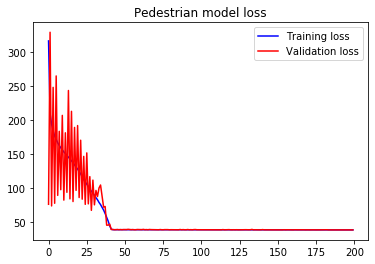

In [14]:
history.history.keys()
ax1,=plt.plot( history.history['loss'], c='b', label='Training loss')
ax2,=plt.plot( history.history['val_loss'], c='r', label='Validation loss')

plt.legend(handles=[ax1,ax2])
plt.title('Pedestrian model loss')
plt.savefig('p_loss')
plt.show()

In [15]:
# final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
# final_model.load_weights('home+ '/repo/planning/traj_pred/total_model_history/veh_weights.h5'')

In [16]:
# ##prediction
# # from utilities import get_position_sequence
# def get_position_sequence(prev, new):
#     arr = np.delete(prev, 0, 0)
#     a=np.vstack((arr,new))
#     return a 

# def get_sequence_prediction(X_position_test, i):
#     results =[]
#     s=X_position_test[i]
#     for count in range(0,50):
        
#         result = final_model.predict(np.array([s]))
# #         print(result)
#         results.append(result[0])
#         s = get_position_sequence(s, result)
#     results=np.array(results)
# #     print(s.shape,results.shape)
    
#     return results

# # i= np.random.randint(0, len(X_test))
# # results = get_sequence_prediction(X_test, i)
# # print(results.shape)

# test=np.load('vehicle_test_history.npy')
# v_predict=[]
# print(len(test))
# for i in range(len(test)):
#     print(i)
#     results = get_sequence_prediction(test, i)
#     v_predict.append(results)
# np.save("v_predictions",v_predict)

# print('done')

In [17]:
# print(np.array(v_predict).shape)
# np.save("v_predictions",v_predict)
# print('done')

In [18]:
# i= np.random.randint(0, len(X_test))


# # In[ ]:
# # i =2273

# # i=1574
# # i=3070

# # i=387,39
# # i=667
# # i=15
# print("showing trip", i)


# # from utilities import get_position_sequence
# def get_position_sequence(prev, new):
#     arr = np.delete(prev, 0, 0)
#     a=np.vstack((arr,new))
#     return a 

# def get_sequence_prediction(X_position_test, i):
#     results =[]
#     s=X_position_test[i]
#     for count in range(0,12):
        
#         result = final_model.predict(np.array([s]))
# #         print(result)
#         results.append(result[0])
#         s = get_position_sequence(s, result)
#     results=np.array(results)
# #     print(s.shape,results.shape)
    
#     return results

# results = get_sequence_prediction(X_test, i)

# # print(len(results))
# # print("sss",results)

# ax1 =plt.scatter(y_test[i][:,0],y_test[i][:,1],color='b',label='Ground truth')

# ax2 =plt.scatter(X_test[i][:,0],X_test[i][:,1],color='r', label='Training segment')


# ax3 =plt.scatter(results[:,0],results[:,1],color='g', label='Prediction')
# # ax3 =plt.scatter(result[0][0],result[0][1],color='g', label='Prediction')

# plt.legend(handles=[ax1, ax2, ax3])
# plt.show()

# distance = v3_displacement_error(results,y_test[i] )
# avg = K.mean(distance)
# pl =[]
# # tf.print(distance,output_stream=sys.stderr)
# with tf.compat.v1.Session() as sess: pl=distance.eval(), print(distance.eval(),'\naverage',avg.eval()) 
# import matplotlib.pyplot as plt
# # print(pl[0])
# plt.plot(pl[0])
# plt.title('Displacement error')
# plt.show()

In [19]:
# final_displacement=[]
# avg_displacement=[]

# # for idx in range(0,len(X_test)):
# for idx in range(0,1000):
#     p=[]
#     re= get_sequence_prediction(X_test, idx)
#     distance = v3_displacement_error(re,y_test[idx] )
#     avg = K.mean(distance)
    
#     with tf.compat.v1.Session() as sess:
#         p=distance.eval()
#         ax =avg.eval()
# #     print(p,ax)
#     final_displacement.append(p)
#     avg_displacement.append(ax)

# final_displacement = np.array(final_displacement)
# sec=[]

# for j in range(0,final_displacement.shape[1]):
#     displacement = sum(final_displacement[:,j])/len(final_displacement)
    
#     sec.append(displacement)
# print("Final displacement error:",sec[-1])
# print("Average displacement error:",sum(avg_displacement)/len(avg_displacement))

# print(sec)
# plt.plot(sec)
# plt.title("average displacement error at each timestep")
# plt.show()



In [20]:
# history2 = pickle.load(open( cwd+ '/saved_model/lab1_txt_max_history_mae_adadelta_600.sav',  "rb") ) 
# history3 = pickle.load(open( cwd+ '/saved_model/lab1_txt_max_history_mae_adadelta.sav',  "rb") )
# print(len(history.history['loss']))
# # plt.plot(range(600,1100),history.history['loss'], c='b')
# # plt.plot( range(300,600), history2['loss'], c='b')
# plt.plot( history3['loss'], c='b')
# plt.title('train loss')

# # plt.plot(range(600,1100),history.history['val_loss'], c='r')
# # plt.plot( range(300,600), history2['val_loss'], c='r')
# plt.plot( history3['val_loss'], c='r')
# plt.title('loss')


# plt.show()